In [33]:
import sys
import os
sys.path.append(os.path.abspath("./MLP"))
sys.path.append(os.path.abspath("./datasets"))
sys.path.append(os.path.abspath("./KAN"))
from MLP import MLP
from MLPWrapper import MLPWrapper
from convert_data_to_input import CreateInput
from KAN import KANWrapper
from KAN_model import KANModel
import torch
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neural_network,pipeline,preprocessing,linear_model
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Prepare data

In [34]:
# get input data
deepmimo = True
sequence = False

function_folder = "deepmimo-pink_-0.017"

data = CreateInput(function_folder, True)

tensors = data.get_tensors()

            0         1         2         3         4         5         6  \
0    0.056396  1.237230  1.122785  0.059215  1.350631  1.369739  0.675815   
1    0.375690  1.120393  1.506980  0.355062  0.597543  0.457111 -0.653185   
2    0.962757  0.617716  0.932218  1.324570  1.057754  1.242442  1.368808   
3    0.677730  0.517215  1.133391  1.225095  0.745943  0.960966  0.754221   
4   -0.701934 -0.562489 -0.002838 -0.693269  0.205243 -0.122041 -1.389771   
..        ...       ...       ...       ...       ...       ...       ...   
135  0.306265 -0.186914  0.572346  0.265317 -0.216168  0.765338  1.541803   
136  1.205388 -0.084093  0.670013  0.498232  0.103157  1.200158  1.258339   
137 -0.890718  0.340059  0.518667 -0.168233  0.280668  0.448169 -0.307616   
138  0.540978  0.882196  1.125111  0.727502  1.321820  0.527239  0.711979   
139  0.143716  0.169053  0.725862  0.690320  0.506089  0.774742  0.666798   

            7         8         9  ...      1014      1015      1016  \
0  

In [35]:
tensors['train'][1].shape

torch.Size([140, 1024])

# Evaluate KAN

In [36]:
# find optimal params for KAN

kan_wrapper = KANWrapper(data=tensors,deepmimo=True)

input_size = tensors['test'][1].shape[1]

if sequence:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[input_size, 2*input_size + 1, input_size],
                       [input_size, 20, input_size], [input_size, 20, 20, input_size], [input_size, 20, 20, 20, input_size],
                       [input_size, 10, input_size],
                       [input_size, 5, input_size],
                       [input_size, 20, 10, 20, input_size], [input_size, 10, 5, 10, input_size]], 
        'kan__grid': [3, 5],
        'kan__k': [3, 5],
        'kan__seed': [42],
        'kan__lr': [0.01],
        'kan__lamb': [0],
        'kan__deepmimo': [True],
        'kan__epochs': [10]
    }

elif deepmimo:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[1024]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001],
        'kan__lamb': [0],
        'kan__deepmimo': [True]
    }



# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kan', kan_wrapper)
])

# Initialize RandomizedSearchCV
"""grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,                           # Number of parameter settings sampled
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=2
)"""
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)
# Fit RandomizedSearchCV
if not deepmimo:
    grid_search.fit(kan_wrapper.X_train, kan_wrapper.y_train)

    # Retrieve the best parameters and best score
    grid_search.best_params_['kan__data'] = []          # remove annoying print
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Score:", grid_search.best_score_)

    opt_params_KAN = grid_search.best_params_


In [37]:
# evaluate KAN with optimal params
if not deepmimo:
    kan_model = KANModel(width=opt_params_KAN['kan__width'], grid=opt_params_KAN['kan__grid'], k=opt_params_KAN['kan__k'], seed=opt_params_KAN['kan__seed'], lr=opt_params_KAN['kan__lr'], lamb=opt_params_KAN['kan__lamb'], deepmimo=True, epochs=50, results_path=f"./results/KAN/{function_folder}")
    kan_model.load_data(tensors)
    loss_data, time_elapsed = kan_model.fit()
    y_preds = kan_model.predict()

In [39]:
if deepmimo:
    kan_model = KANModel(width=[1024, 10, 1024], grid=10, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,epochs=10, results_path=f"./results/KAN/{function_folder}")
    kan_model.load_data(tensors)
    loss_data, time_elapsed = kan_model.fit()
    y_preds = kan_model.predict()
results = {}
results["test_loss"] = y_preds['test_loss']

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.12e-01 | test_loss: 1.26e+00 | reg: 1.13e+03 | : 100%|█| 10/10 [00:18<00:00,  1.81s/


saving model version 0.1


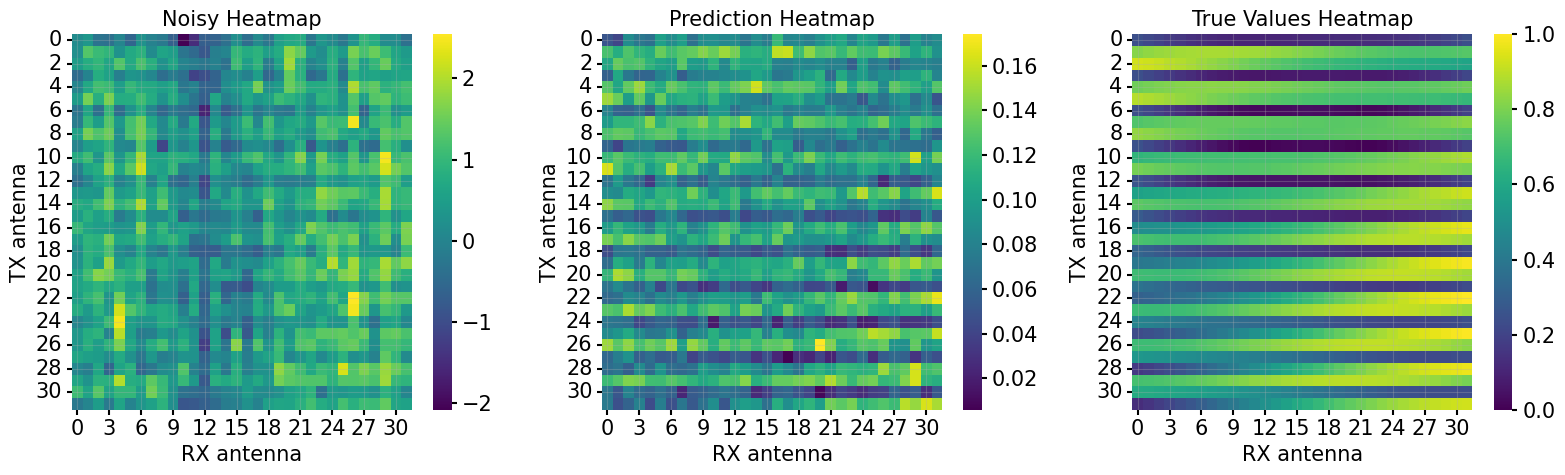

In [40]:
# plot pred and true
if deepmimo:
    noisy_sample = tensors['test'][0][5]
    pred_sample = y_preds['preds'][5]
    true_sample = tensors['test'][1][5]
    kan_model.plot_deepmimo_with_noise(true_sample=true_sample, pred_sample=pred_sample,noisy_sample=noisy_sample, save=False)
else:
    kan_model.plot_sequence(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)

In [41]:
if deepmimo:
    num_samples = tensors['test'][0].shape
    noisy = tensors['test'][0] # [20, 1024]
    true = tensors['test'][1]

    average_mse = torch.mean(torch.sum((noisy-true)**2, axis=1))
    print(f"Average MSE per sample between noisy and true: {average_mse}")
    results['noise-average-mse'] = average_mse

Average MSE per sample between noisy and true: 409.0831604003906


In [42]:
# diffrence pred and true
if deepmimo:
    num_samples = tensors['test'][0].shape
    preds = y_preds['preds']
    true = tensors['test'][1]

    average_mse = torch.mean(torch.sum((preds-true)**2, axis=1))
    print(f"Average MSE per sample between predicted and true for KAN: {average_mse}")
    results['pred-average-mse'] = average_mse
    #kan_model.write_params_to_file(results)

Average MSE per sample between predicted and true for KAN: 1725.028564453125


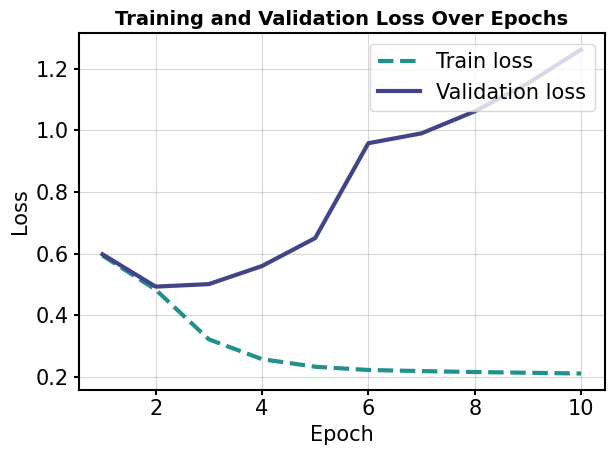

In [43]:
# plot loss
kan_model.plot_loss(loss_data=loss_data, save=False)

# Evaluate MLP

In [44]:
# find optimal params for mlp
mlp_wrapper = MLPWrapper(data=tensors,deepmimo=True)

if deepmimo:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1024],
        'mlp__hidden_size': [[64,64],[500,500],[1000],[300,300,300],[128,128], [2000]],
        'mlp__output_size': [1024],
        'mlp__epochs': [100],
        'mlp__lr': [0.01,0.1,0.001],
        'mlp__deepmimo': [True]
    }
else:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [input_size],
        'mlp__hidden_size': [[2*input_size + 1],
                       [20],
                       [10],
                       [5],
                       [20, 10, 20], [10, 5, 10]],
        'mlp__output_size': [input_size],
        'mlp__epochs': [10],
        'mlp__deepmimo': [True],
        'mlp__lr': [0.01]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    #('scaler', StandardScaler()),  # Example preprocessor
    ('mlp', mlp_wrapper)
])

# Initialize RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings sampled
    cv=5,        # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)

# Fit RandomizedSearchCV
grid_search.fit(mlp_wrapper.X_train, mlp_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['mlp__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_MLP = grid_search.best_params_

/Users/hampusf/Documents/SCHOOL/DD2434/pink_noise_branch/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_ = torch.tensor(X).float()
/Users/hampusf/Documents/SCHOOL/DD2434/pink_noise_branch/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 47%|████▋     | 47/100 [00:03<00:03, 13.81it/s]/Users/hampusf/Documents/SCHOOL/DD2434/pink_noise_branch/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than 

Best Parameters: {'mlp__output_size': 1024, 'mlp__lr': 0.01, 'mlp__input_size': 1024, 'mlp__hidden_size': [2000], 'mlp__epochs': 100, 'mlp__deepmimo': True, 'mlp__data': []}
Best Cross-Validation Score: -0.0556916669011116


In [45]:
# evaluate KAN with optimal params
mlp_model = MLP(input_size=opt_params_MLP['mlp__input_size'], hidden_sizes=opt_params_MLP['mlp__hidden_size'], output_size=opt_params_MLP['mlp__output_size'],result_path=f"./results/MLP/{function_folder}", lr=opt_params_MLP['mlp__lr'])
mlp_model.load_data(tensors, deepmimo=True)
loss_data_MLP, time_elapsed_MLP = mlp_model.fit(mlp_model.X_train, mlp_model.y_train, n_epochs=50, cross_validation=False, deepmimo=True)
y_preds_MLP = mlp_model.predict(mlp_model.X_test,eval=True)
results = {}
results['test_loss'] = y_preds_MLP['test_loss']

100%|██████████| 50/50 [04:57<00:00,  5.96s/it]


In [46]:
# diffrence pred and true for MLP
if deepmimo:
    num_samples = tensors['test'][0].shape        
    preds = y_preds_MLP['preds']
    true = tensors['test'][1]

    average_mse = torch.mean(torch.sum((preds-true)**2, axis=1))
    print(f"Average MSE per sample between predicted and true for MLP: {average_mse}")
    results['average-pred-loss'] = average_mse

Average MSE per sample between predicted and true for MLP: 5.191902160644531


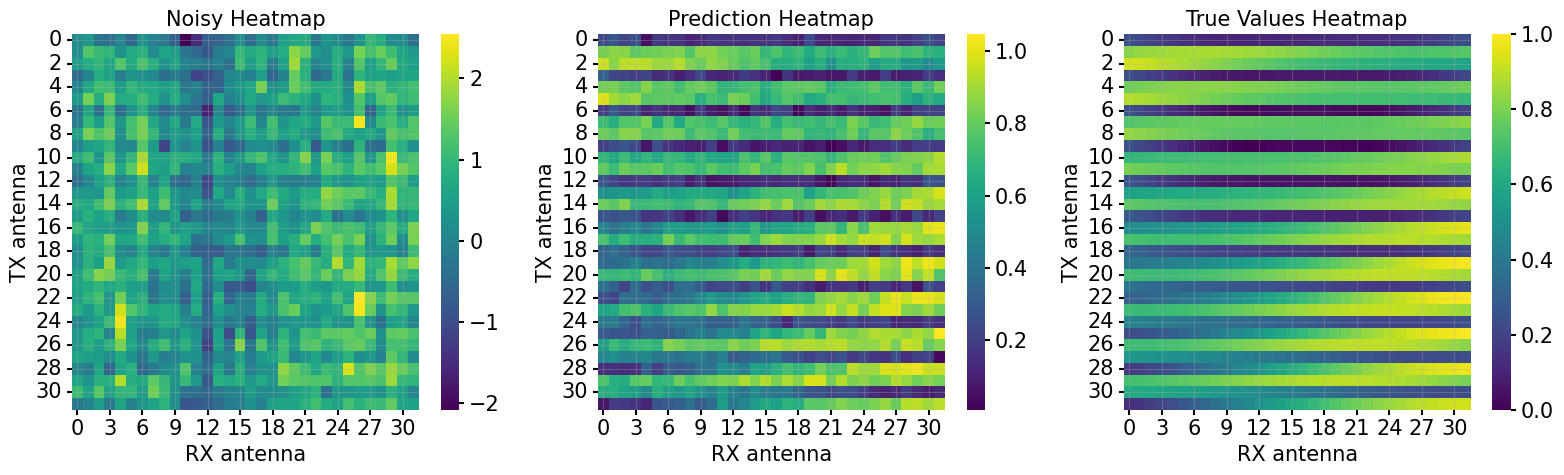

In [47]:
# plot predictions
if deepmimo:
    noisy_sample = tensors['test'][0][5]
    pred_sample = y_preds_MLP['preds'][5]
    true_sample = tensors['test'][1][5]
    mlp_model.plot_deepmimo_with_noise(true_sample=true_sample, pred_sample=pred_sample,noisy_sample=noisy_sample, save=False)
else:
    mlp_model.plot_sequence(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=False)

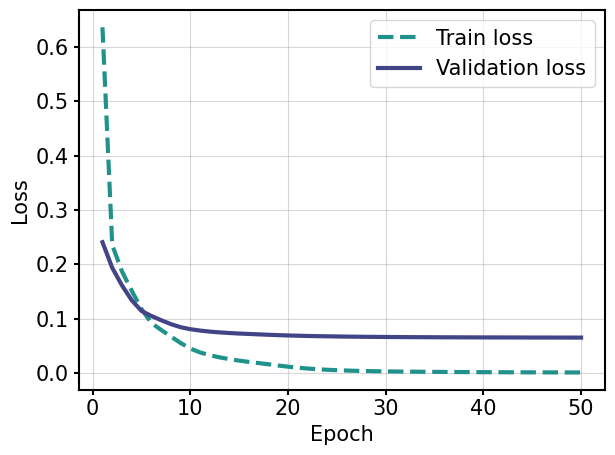

In [48]:

mlp_model.plot_loss(loss_data=loss_data_MLP, save=False, deepmimo=deepmimo)
# plot loss
#mlp_model.write_params_to_file(results)